In [1]:
import jax
import jax.numpy as jnp
from jax import random, jit, value_and_grad


from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

## Fitting

In [2]:
# ── 1) Network definition ───────────────────────────────────────────────────────

def init_mlp_params(layer_sizes, key):
    """Initialize weights and biases for an MLP with given layer sizes."""
    keys = random.split(key, len(layer_sizes) - 1)
    params = []
    for k, (m, n) in zip(keys, zip(layer_sizes[:-1], layer_sizes[1:])):
        # He initialization for weights, zeros for biases
        w = random.normal(k, (m, n)) * jnp.sqrt(2.0 / m)
        b = jnp.zeros(n)
        params.append((w, b))
    return params

def mlp_predict(params, x):
    """Forward pass through the MLP. x has shape (3,); returns scalar."""
    for w, b in params[:-1]:
        x = jnp.tanh(jnp.dot(x, w) + b)
    w_last, b_last = params[-1]
    return jnp.dot(x, w_last) + b_last  # shape (1,)


In [3]:
# ── 2) Synthetic data ─────────────────────────────────────────────────────────

def make_dataset(num_samples, key):
    key, sub = random.split(key)
    # feature1: stimulus ∼ Uniform[0,1]
    x1 = random.uniform(sub, (num_samples,), minval=0.0, maxval=1.0)

    # feature2: divider ∈ {0.25, 0.5, 0.75}
    dividers = jnp.array([0.25, 0.5, 0.75])
    key, sub = random.split(key)
    idx = random.randint(sub, (num_samples,), 0, 3)
    feature2 = dividers[idx]

    # feature3: safe‐side signal ∈ {0 (left), 1 (right)}
    key, sub = random.split(key)
    feature3 = random.randint(sub, (num_samples,), 0, 2)

    feats = jnp.stack([x1, feature2, feature3], axis=1)
    y_true = x1  # exactly equal
    return feats, y_true, key

In [4]:
# ── 3) Loss with sampling + reward ↔ error flip ────────────────────────────────
mae_scale = 0.05  # scale for the MAE loss
uncertainty_scale = 0.4  # scale for the uncertainty in the sampling

def loss_fn(params, features, y_true, key):
    """
    - Predict mean ŷ = f(x)
    - Sample y ~ Normal(ŷ, 0.1²)
    - Compute reward:
        • If y_true on safe side: +1 if y_sample also on safe side else -1
        • If y_true on not‐safe side: +3 if y_sample on not‐safe side else -3
        • Plus small reward for closeness: −|y_sample − y_true|
    - Loss = − mean(total_reward)
    """
    # 1) predict means
    y_mean = jax.vmap(lambda x: mlp_predict(params, x))(features).squeeze()  # (B,)

    # 2) sample with reparameterization
    key, sub = random.split(key)
    eps = random.normal(sub, y_mean.shape) * uncertainty_scale
    y_sample = y_mean + eps

    # unpack
    x1 = y_true
    divider = features[:, 1]
    safe_signal = features[:, 2]

    # where the true y lies
    on_safe = jnp.where(safe_signal == 0, x1 < divider, x1 > divider)
    # where the sampled y lies on the “safe” side
    pred_safe = jnp.where(safe_signal == 0, y_sample < divider, y_sample > divider)

    # classification reward
    reward_class = jnp.where(
        on_safe,
        jnp.where(pred_safe,  1.0, -1.0),   # true-safe → ±1
        jnp.where(~pred_safe, 3.0, -3.0)    # true-not-safe → ±3
    )

    # closeness reward (negative distance)
    reward_dist = -jnp.abs(y_sample - y_true)

    total_reward = reward_class + (mae_scale * reward_dist)

    return -jnp.mean(total_reward)  # flip to turn reward → loss

# jit and gradient helper
loss_and_grad = jit(value_and_grad(loss_fn))



In [5]:
# ── 4) Training loop ──────────────────────────────────────────────────────────

def train(num_epochs=10_000, batch_size=256, lr=1e-3, seed=0):
    # init data + params
    key = random.PRNGKey(seed)
    feats, y_true, key = make_dataset(100_000, key)
    params = init_mlp_params([3, 16, 16, 1], random.PRNGKey(seed + 1))

    loss = []
    for epoch in tqdm(range(1, num_epochs + 1)):
        # (optionally shuffle / batch… here we do full‐batch)
        key, sub = random.split(key)
        loss_val, grads = loss_and_grad(params, feats, y_true, sub)

        # gradient descent step
        params = [
            (w - lr * dw, b - lr * db)
            for (w, b), (dw, db) in zip(params, grads)
        ]

        loss.append(loss_val)

    return params, jnp.array(loss)


In [6]:
trained_params, loss = train(100_000)

100%|██████████| 100000/100000 [01:14<00:00, 1350.04it/s]


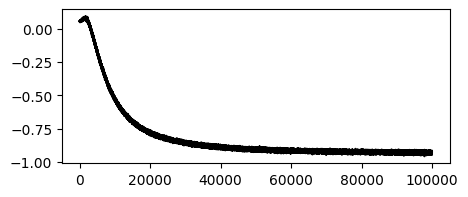

In [7]:
plt.figure(figsize=(5, 2))
plt.plot(loss, "k-")
plt.show()

## Analysis

In [8]:
# lets make 10,000 samples
feats, y_true, key = make_dataset(100_000, random.PRNGKey(0))
y_hats = jax.vmap(lambda x: mlp_predict(trained_params, x))(feats).squeeze()

Text(0, 0.5, 'y_hat - true y')

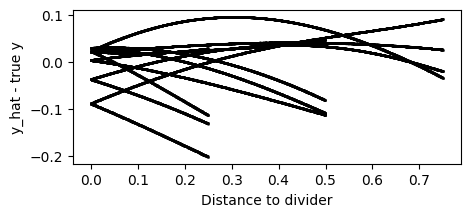

In [9]:
distance_to_divider = jnp.abs(feats[:, 1] - y_true)
y_err =  y_hats - y_true

plt.figure(figsize=(5, 2))
plt.scatter(distance_to_divider, y_err, s=1, c="k", alpha=0.1)
plt.xlabel("Distance to divider")
plt.ylabel("y_hat - true y")

### Checking on the safe side vs on the unsafe side

In [10]:
# aligning safe‐side to left (0) and not‐safe to right (1)
aligned_y_hats = np.zeros((100_000))
aligned_dividers = np.zeros((100_000))
aligned_y = np.zeros((100_000))
for i in tqdm(range(100_000)):
    if feats[i, 2] == 0:  # safe side
        aligned_y_hats[i] = y_hats[i]
        aligned_dividers[i] = feats[i, 1]
        aligned_y[i] = y_true[i]
    else:  # not safe side
        aligned_y_hats[i] = 1 - y_hats[i]
        aligned_dividers[i] = 1 - feats[i, 1]
        aligned_y[i] = 1 - y_true[i]

100%|██████████| 100000/100000 [01:33<00:00, 1073.19it/s]


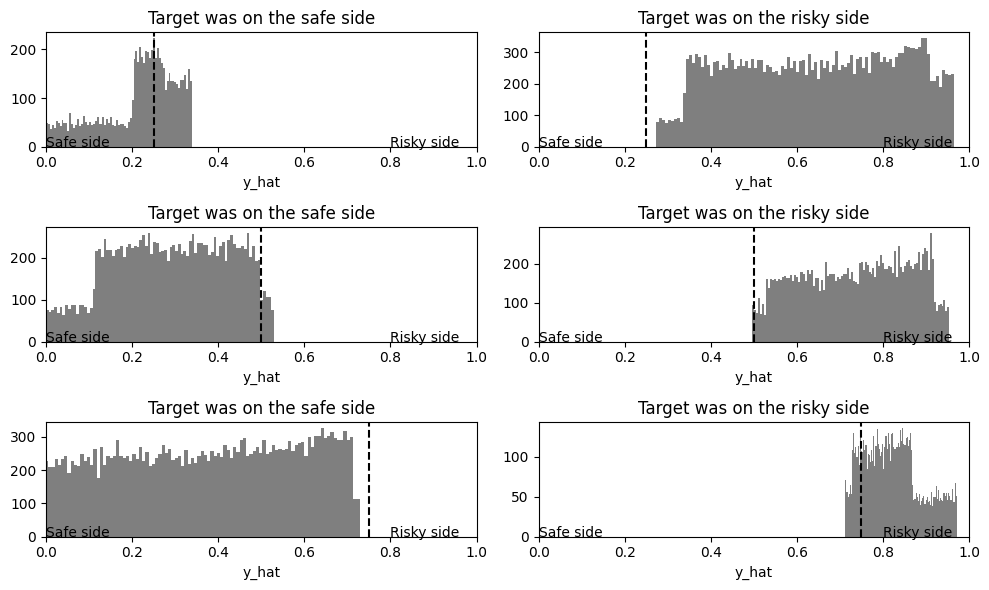

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(10, 6))

divider_locations = [0.25, 0.5, 0.75]
for i in range(3):
    masks = [(aligned_dividers == divider_locations[i]) & (aligned_y <= divider_locations[i]),
            (aligned_dividers == divider_locations[i]) & (aligned_y >= divider_locations[i])]

    titles = ["Target was on the safe side", 
            "Target was on the risky side"]
    
    ax = axs[i, :]
    for j, a in enumerate(ax):
        a.hist(aligned_y_hats[masks[j]], bins=100, color="k", alpha=0.5)
        a.set_xlabel("y_hat")
        a.set_xlim(0, 1)
        a.set_title(titles[j])

        a.axvline(divider_locations[i], color="k", linestyle="--")
        a.text(0, 0, "Safe side", color="k", fontsize=10)
        a.text(0.8, 0, "Risky side", color="k", fontsize=10)
        
plt.tight_layout()